# Gene essentiality

In [110]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pandas import DataFrame
from cameo import load_model, fba
from cameo.util import TimeMachine
from cameo import exceptions
model = load_model('data/e_coli_core.xml.gz')

## Knocking out a single gene

Is [pgk](http://ecocyc.org/gene?orgid=ECOLI&id=EG10703) (the gene encoding [phosphoglycerate kinase](http://bigg.ucsd.edu/universal/reactions/PGK)) essential? Let's find out. In the model, exactly one gene is associated with reaction PGK (it has the Blattner number b2926).

In [35]:
model.reactions.PGK.genes

frozenset({<Gene b2926 at 0x119e0fef0>})

Checking the name of this gene in the model (the id is the Blattner number b2926), reveals that it is indeed [pgk](http://ecocyc.org/gene?orgid=ECOLI&id=EG10703).

In [36]:
model.genes.b2926.name

'pgk'

Add gene stuff from course + exercise

## Perform all possible single gene deletions

Using a simple `for` loop allows to iterate over all genes in the model and knock out each one of them. Of course we're using `TimeMachine` to undo every gene deletion before proceeding to the next knockout.

In [37]:
essentiality = {}
for gene in model.genes:
    with TimeMachine() as tm:
        gene.knock_out(time_machine=tm)
        try:
            solution = model.solve()
        except exceptions.Infeasible:
            solution
        else:
            essentiality[gene] = solution.objective_value

In [38]:
essentiality

{<Gene b2926 at 0x119e0fef0>: -3.5892994893890636e-16,
 <Gene b2277 at 0x119e0f048>: 0.2116629497353121,
 <Gene b1854 at 0x119e11b70>: 0.8739215069684287,
 <Gene b3925 at 0x119de8ef0>: 0.8739215069684273,
 <Gene b2029 at 0x119e0e080>: 0.8638133095040009,
 <Gene b3236 at 0x119e0eac8>: 0.8258192905969887,
 <Gene b3528 at 0x119e130b8>: 0.8739215069684304,
 <Gene b1761 at 0x119e09828>: 0.8513885233462086,
 <Gene b2281 at 0x119e0f0f0>: 0.2116629497353121,
 <Gene b0755 at 0x119e11208>: 0.8739215069684294,
 <Gene b3738 at 0x119dfe128>: 0.37422987493311194,
 <Gene b3733 at 0x119dfe160>: 0.3742298749331102,
 <Gene b2280 at 0x119e0f240>: 0.2116629497353121,
 <Gene b0904 at 0x119de8198>: 0.8739215069684273,
 <Gene b2935 at 0x119e13c50>: 0.8739215069684285,
 <Gene b0115 at 0x119e0f7b8>: 0.7966959254309544,
 <Gene b2276 at 0x119e0f1d0>: 0.2116629497353121,
 <Gene b0978 at 0x119df3c50>: 0.873921506968427,
 <Gene b2288 at 0x119e0f208>: 0.2116629497353121,
 <Gene b3739 at 0x119dfe240>: 0.8739215069684

In [112]:
df = DataFrame.from_dict(essentiality, orient='index')
df = df.rename(columns={0: 'growth'})
df = df.sort_values('growth')

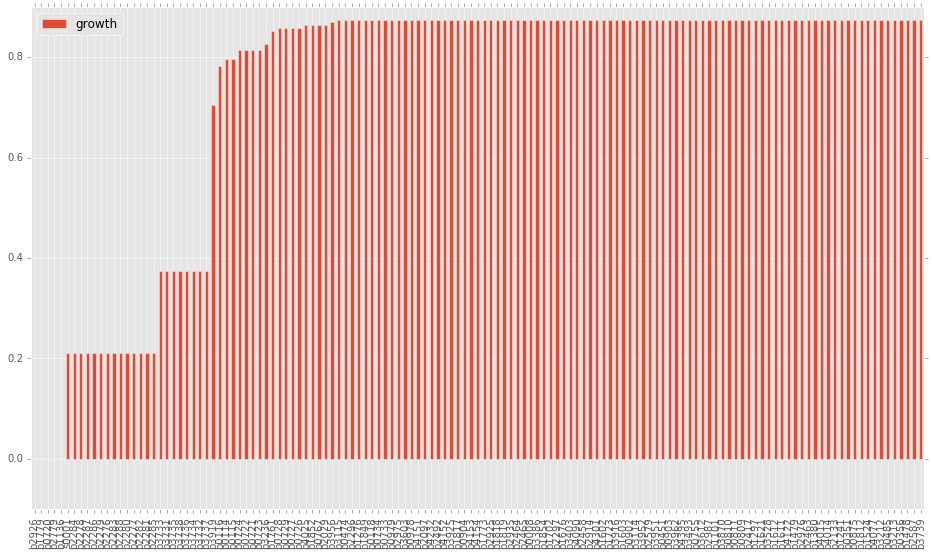

In [113]:
ax = df.plot.bar().axes
ax.figure.set_size_inches(16, 9)

## Gene essentiality with respect to each biomass precursor

In [114]:
biomass_precursors = model.reactions.BIOMASS_Ecoli_core_w_GAM.reactants
len(biomass_precursors)

16

In [164]:
model_copy = model.copy()
precursor_essentiality = {}
for precursor in biomass_precursors:
    print('Determining essentiality profile for precursor: ' + precursor.id)
    precursor_essentiality[precursor.name] = {}
    demand = model_copy.add_exchange(precursor)
    model_copy.objective = demand
    for gene in model_copy.genes:
        with TimeMachine() as tm:
            gene.knock_out(time_machine=tm)
            try:
                solution = model_copy.solve()
            except:
                precursor_essentiality[precursor.name][gene.name] = 0
            else:
                precursor_essentiality[precursor.name][gene.name] = solution.objective_value

Determining essentiality profile for precursor: nad_c
Determining essentiality profile for precursor: accoa_c
Determining essentiality profile for precursor: nadph_c
Determining essentiality profile for precursor: e4p_c
Determining essentiality profile for precursor: g3p_c
Determining essentiality profile for precursor: oaa_c
Determining essentiality profile for precursor: pyr_c
Determining essentiality profile for precursor: r5p_c
Determining essentiality profile for precursor: atp_c
Determining essentiality profile for precursor: gln__L_c
Determining essentiality profile for precursor: h2o_c
Determining essentiality profile for precursor: pep_c
Determining essentiality profile for precursor: glu__L_c
Determining essentiality profile for precursor: g6p_c
Determining essentiality profile for precursor: 3pg_c
Determining essentiality profile for precursor: f6p_c


In [179]:
df = DataFrame.from_dict(precursor_essentiality)
df

,3-Phospho-D-glycerate,ATP,Acetyl-CoA,Alpha-D-Ribose 5-phosphate,D-Erythrose 4-phosphate,D-Fructose 6-phosphate,D-Glucose 6-phosphate,Glyceraldehyde 3-phosphate,H2O,L-Glutamate,L-Glutamine,Nicotinamide adenine dinucleotide,Nicotinamide adenine dinucleotide phosphate - reduced,Oxaloacetate,Phosphoenolpyruvate,Pyruvate
aceA,19.623333,3.615089e-15,0.000000e+00,10.092000,12.393684,8.511325,8.511325,16.055455,1000.0,10.0,10.0,0.000000e+00,3.779731e-16,19.623333,19.623333,20.0
aceB,19.623333,3.615089e-15,0.000000e+00,10.092000,12.393684,8.511325,8.511325,16.055455,1000.0,10.0,10.0,0.000000e+00,3.779731e-16,19.661000,19.623333,20.0
aceE,19.548000,1.793084e-14,0.000000e+00,9.774000,11.968163,8.259718,8.259718,15.432632,1000.0,10.0,10.0,-2.006639e-16,2.893538e-15,19.548000,19.548000,20.0
aceF,19.548000,1.793084e-14,0.000000e+00,9.774000,11.968163,8.259718,8.259718,15.432632,1000.0,10.0,10.0,-2.006639e-16,2.893538e-15,19.548000,19.548000,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tpiA,10.000000,-8.676215e-16,-1.082563e-16,9.631875,10.000000,8.330270,8.330270,10.000000,1000.0,5.0,5.0,-8.231169e-16,0.000000e+00,10.000000,10.000000,10.0
ydjI,19.623333,-1.578441e-14,0.000000e+00,10.092000,12.393684,8.511325,8.511325,16.055455,1000.0,10.0,10.0,0.000000e+00,-2.422382e-16,19.661000,19.623333,20.0
ytjC,19.623333,-2.169054e-16,0.000000e+00,10.092000,12.393684,8.511325,8.511325,16.055455,1000.0,10.0,10.0,-1.646234e-15,1.763875e-15,19.661000,19.623333,20.0
zwf,19.623333,1.879847e-15,0.000000e+00,10.092000,12.393684,8.511325,8.511325,16.055455,1000.0,10.0,10.0,0.000000e+00,1.259910e-16,19.661000,19.623333,20.0


In [166]:
def scale(x):
    return (x - x.min()) / x.max()
        
df = df.apply(scale, axis=1)
df

,3-Phospho-D-glycerate,ATP,Acetyl-CoA,Alpha-D-Ribose 5-phosphate,D-Erythrose 4-phosphate,D-Fructose 6-phosphate,D-Glucose 6-phosphate,Glyceraldehyde 3-phosphate,H2O,L-Glutamate,L-Glutamine,Nicotinamide adenine dinucleotide,Nicotinamide adenine dinucleotide phosphate - reduced,Oxaloacetate,Phosphoenolpyruvate,Pyruvate
aceA,0.019623,3.615089e-18,0.000000e+00,0.010092,0.012394,0.008511,0.008511,0.016055,1.0,0.010,0.010,0.000000e+00,3.779731e-19,0.019623,0.019623,0.02
aceB,0.019623,3.615089e-18,0.000000e+00,0.010092,0.012394,0.008511,0.008511,0.016055,1.0,0.010,0.010,0.000000e+00,3.779731e-19,0.019661,0.019623,0.02
aceE,0.019548,1.813151e-17,2.006639e-19,0.009774,0.011968,0.008260,0.008260,0.015433,1.0,0.010,0.010,0.000000e+00,3.094202e-18,0.019548,0.019548,0.02
aceF,0.019548,1.813151e-17,2.006639e-19,0.009774,0.011968,0.008260,0.008260,0.015433,1.0,0.010,0.010,0.000000e+00,3.094202e-18,0.019548,0.019548,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tpiA,0.010000,0.000000e+00,7.593652e-19,0.009632,0.010000,0.008330,0.008330,0.010000,1.0,0.005,0.005,4.450462e-20,8.676215e-19,0.010000,0.010000,0.01
ydjI,0.019623,0.000000e+00,1.578441e-17,0.010092,0.012394,0.008511,0.008511,0.016055,1.0,0.010,0.010,1.578441e-17,1.554217e-17,0.019661,0.019623,0.02
ytjC,0.019623,1.429328e-18,1.646234e-18,0.010092,0.012394,0.008511,0.008511,0.016055,1.0,0.010,0.010,0.000000e+00,3.410108e-18,0.019661,0.019623,0.02
zwf,0.019623,1.879847e-18,0.000000e+00,0.010092,0.012394,0.008511,0.008511,0.016055,1.0,0.010,0.010,0.000000e+00,1.259910e-19,0.019661,0.019623,0.02


In [196]:
list(df.itertuples())

[Pandas(Index='aceA', _1=19.623333333333328, ATP=3.6150894952938501e-15, _3=0.0, _4=10.092000000000006, _5=12.393684210526306, _6=8.511325301204824, _7=8.5113253012048187, _8=16.055454545454538, H2O=1000.0, _10=10.0, _11=10.000000000000004, _12=0.0, _13=3.7797311033530512e-16, Oxaloacetate=19.623333333333331, Phosphoenolpyruvate=19.623333333333274, Pyruvate=20.000000000000028),
 Pandas(Index='aceB', _1=19.623333333333328, ATP=3.6150894952938501e-15, _3=0.0, _4=10.092000000000006, _5=12.393684210526306, _6=8.511325301204824, _7=8.5113253012048187, _8=16.055454545454538, H2O=1000.0, _10=10.0, _11=10.000000000000004, _12=0.0, _13=3.7797311033530512e-16, Oxaloacetate=19.660999999999998, Phosphoenolpyruvate=19.623333333333274, Pyruvate=20.000000000000028),
 Pandas(Index='aceE', _1=19.548000000000002, ATP=1.7930843896657497e-14, _3=0.0, _4=9.7739999999999903, _5=11.96816326530611, _6=8.25971830985916, _7=8.2597183098591582, _8=15.432631578947356, H2O=1000.0, _10=10.0, _11=10.000000000000004,

In [195]:
x, y, z = [], [], []
for col_id, row_id, value in df.itertuples():
    x.append(col_id)
    y.append(row_id)
    z.append(value)

ValueError: too many values to unpack (expected 3)

In [180]:
from bokeh.charts import HeatMap, show

In [183]:
df.index.values

array(['aceA', 'aceB', 'aceE', 'aceF', 'ackA', 'acnA', 'acnB', 'adhE',
       'adhP', 'adk', 'amtB', 'aqpZ', 'atpA', 'atpB', 'atpC', 'atpD',
       'atpE', 'atpF', 'atpG', 'atpH', 'atpI', 'cbdA', 'cbdB', 'crr',
       'cydA', 'cydB', 'dctA', 'dld', 'eno', 'eutD', 'fbaA', 'fbaB', 'fbp',
       'focA', 'focB', 'frdA', 'frdB', 'frdC', 'frdD', 'frmA', 'fumA',
       'fumB', 'fumC', 'gapA', 'gdhA', 'glcA', 'glcB', 'glnA', 'glnH',
       'glnP', 'glnQ', 'glpX', 'glsA', 'glsB', 'gltA', 'gltB', 'gltD',
       'gltP', 'gnd', 'gpmA', 'gpmM', 'grcA', 'icd', 'kgtP', 'ldhA',
       'lldP', 'lpd', 'maeA', 'maeB', 'malX', 'manX', 'manY', 'manZ',
       'mdh', 'mhpF', 'nuoA', 'nuoB', 'nuoC', 'nuoE', 'nuoF', 'nuoG',
       'nuoH', 'nuoI', 'nuoJ', 'nuoK', 'nuoL', 'nuoM', 'nuoN', 'pabB',
       'pck', 'pfkA', 'pfkB', 'pflA', 'pflB', 'pflC', 'pflD', 'pgi', 'pgk',
       'pgl', 'pitA', 'pitB', 'pntA', 'pntB', 'ppc', 'ppsA', 'pta', 'ptsG',
       'ptsH', 'ptsI', 'purT', 'puuA', 'pykA', 'pykF', 'rpe', 'rpiA'

In [186]:
p = HeatMap(df, x=df.columns.values, y=df.index.values)

show(p)

ValueError: expected an element of either Column Name or Column String or List(Column Name or Column String), got array(['3-Phospho-D-glycerate', 'ATP', 'Acetyl-CoA',
       'Alpha-D-Ribose 5-phosphate', 'D-Erythrose 4-phosphate',
       'D-Fructose 6-phosphate', 'D-Glucose 6-phosphate',
       'Glyceraldehyde 3-phosphate', 'H2O', 'L-Glutamate', 'L-Glutamine',
       'Nicotinamide adenine dinucleotide',
       'Nicotinamide adenine dinucleotide phosphate - reduced',
       'Oxaloacetate', 'Phosphoenolpyruvate', 'Pyruvate'], dtype=object)

In [173]:
df

,3-Phospho-D-glycerate,ATP,Acetyl-CoA,Alpha-D-Ribose 5-phosphate,D-Erythrose 4-phosphate,D-Fructose 6-phosphate,D-Glucose 6-phosphate,Glyceraldehyde 3-phosphate,H2O,L-Glutamate,L-Glutamine,Nicotinamide adenine dinucleotide,Nicotinamide adenine dinucleotide phosphate - reduced,Oxaloacetate,Phosphoenolpyruvate,Pyruvate
aceA,19.623333,3.615089e-15,0.000000e+00,10.092000,12.393684,8.511325,8.511325,16.055455,1000.0,10.0,10.0,0.000000e+00,3.779731e-16,19.623333,19.623333,20.0
aceB,19.623333,3.615089e-15,0.000000e+00,10.092000,12.393684,8.511325,8.511325,16.055455,1000.0,10.0,10.0,0.000000e+00,3.779731e-16,19.661000,19.623333,20.0
aceE,19.548000,1.793084e-14,0.000000e+00,9.774000,11.968163,8.259718,8.259718,15.432632,1000.0,10.0,10.0,-2.006639e-16,2.893538e-15,19.548000,19.548000,20.0
aceF,19.548000,1.793084e-14,0.000000e+00,9.774000,11.968163,8.259718,8.259718,15.432632,1000.0,10.0,10.0,-2.006639e-16,2.893538e-15,19.548000,19.548000,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tpiA,10.000000,-8.676215e-16,-1.082563e-16,9.631875,10.000000,8.330270,8.330270,10.000000,1000.0,5.0,5.0,-8.231169e-16,0.000000e+00,10.000000,10.000000,10.0
ydjI,19.623333,-1.578441e-14,0.000000e+00,10.092000,12.393684,8.511325,8.511325,16.055455,1000.0,10.0,10.0,0.000000e+00,-2.422382e-16,19.661000,19.623333,20.0
ytjC,19.623333,-2.169054e-16,0.000000e+00,10.092000,12.393684,8.511325,8.511325,16.055455,1000.0,10.0,10.0,-1.646234e-15,1.763875e-15,19.661000,19.623333,20.0
zwf,19.623333,1.879847e-15,0.000000e+00,10.092000,12.393684,8.511325,8.511325,16.055455,1000.0,10.0,10.0,0.000000e+00,1.259910e-16,19.661000,19.623333,20.0


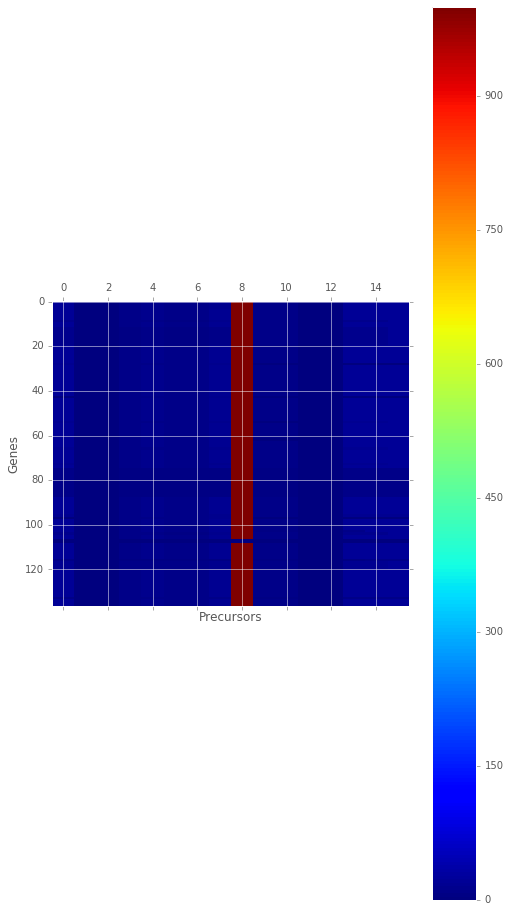

In [188]:
from matplotlib import pyplot as plt
from matplotlib import colorbar
x = plt.matshow(df)
ax = x.axes
plt.colorbar(mappable=x, ax=ax)
ax.figure.set_figwidth(8)
ax.set_aspect(.1)
ax.set_xlabel('Precursors')
ax.set_ylabel('Genes')
plt.show()

## Exercises

1. How many genes are in each category (essential and non-essential)? How many non-essential genes show a reduced growth rate?
2. Determine the essentialiy of genes for all other available carbon sources (if this is too complicated, determine the essentiality profile for one other carbon source).

Hints:
* Sometimes an optimal solution cannot be found for certain knockouts (an exception is raised). Use `try` and 

### Solution 1

In [13]:
wt_growth_rate = model.solve().objective_value
essential = 0
reduced_growth = 0
same_growth = 0
for gene, growth in essentiality.items():
    if growth < 0.05:
        essential = essential + 1
    elif growth > wt_growth_rate * .95:
        same_growth = same_growth + 1
    else:
        reduced_growth = reduced_growth + 1

In [14]:
essential

5

In [15]:
reduced_growth

0

In [16]:
same_growth

130

### Solution 2

In [17]:
carbon_exchanges = ['EX_ac_e', 'EX_etoh_e', 'EX_for_e',
                    'EX_fru_e', 'EX_fum_e', 'EX_glc__D_e', 'EX_glc__D_e',
                    'EX_lac__D_e', 'EX_mal__L_e', 'EX_pyr_e', 'EX_succ_e']

In [18]:
model.reactions.EX_glc__D_e

Id,EX_glc__D_e
Name,D-Glucose exchange
Stoichiometry,glc__D_e <=>
GPR,
Lower bound,-10.000000
Upper bound,1000.000000


In [28]:
result = {}
with TimeMachine() as tm:
    model.reactions.EX_glc__D_e.change_bounds(0, 0, time_machine=tm)
    for source in carbon_exchanges:
        print('Determining essentiality for: ' + source)
        result[source] = {}
        model.reactions.get_by_id(source).change_bounds(-20, 0, time_machine=tm)
        for gene in model.genes:
            with TimeMachine() as tm2:
                gene.knock_out(time_machine=tm2)
                try:
                    solution = model.solve()
                except exceptions.Infeasible:
                    result[source][gene] = 0.
                else:
                    result[source][gene] = solution.objective_value

Determining essentiality for: EX_ac_e
Determining essentiality for: EX_etoh_e
Determining essentiality for: EX_for_e
Determining essentiality for: EX_fru_e
Determining essentiality for: EX_fum_e
Determining essentiality for: EX_glc__D_e
Determining essentiality for: EX_glc__D_e
Determining essentiality for: EX_lac__D_e
Determining essentiality for: EX_mal__L_e
Determining essentiality for: EX_pyr_e
Determining essentiality for: EX_succ_e


In [29]:
from pandas import DataFrame

In [104]:
df = DataFrame.from_dict(precursor_essentiality)
(df - df.mean()) / (df.max() - df.min())

,f6p_c,pyr_c,3pg_c,h2o_c,gln__L_c,r5p_c,atp_c,g6p_c,g3p_c,nad_c,nadph_c,accoa_c,oaa_c,pep_c,e4p_c,glu__L_c
b1854,0.084151,0.092457,0.112820,0.014599,0.126883,0.087025,-0.074206,0.083830,0.100150,NaN,-0.065693,-0.258647,0.120122,0.120072,0.092475,0.109489
b3236,0.042382,0.092457,0.107335,0.014599,0.126883,0.042541,-0.072800,0.042062,0.045554,NaN,-0.065693,-0.134038,0.112733,0.114588,0.044062,0.109489
b2276,-0.354538,-0.407543,-0.454362,0.014599,-0.423470,-0.378317,-0.092897,-0.354859,-0.446421,NaN,-0.065693,-0.027130,-0.447889,-0.447110,-0.407445,-0.390511
b0118,0.084151,0.092457,0.112820,0.014599,0.126883,0.087025,0.044998,0.083830,0.100150,NaN,-0.065693,-0.098402,0.120122,0.120072,0.092475,0.109489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4395,0.084151,0.092457,0.112820,0.014599,0.126883,0.087025,-0.074206,0.083830,0.100150,NaN,-0.065693,-0.258647,0.120122,0.120072,0.092475,0.109489
b2286,-0.354538,-0.407543,-0.454362,0.014599,-0.423470,-0.378317,-0.092897,-0.354859,-0.446421,NaN,-0.065693,-0.027130,-0.447889,-0.447110,-0.407445,-0.390511
b4152,0.084151,0.092457,0.112820,0.014599,0.126883,0.087025,-0.059802,0.083830,0.100150,NaN,-0.065693,-0.205310,0.120122,0.120072,0.092475,0.109489
b0115,0.054589,0.092457,0.108981,0.014599,0.126883,0.055515,-0.092897,0.054269,0.061358,NaN,-0.065693,0.130770,0.114375,0.116233,0.058141,0.109489


In [23]:
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pandas.DataFrame(x_scaled)

In [24]:
min_max_scaler = preprocessing.MinMaxScaler()
DataFrame(min_max_scaler.fit_transform(df))

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
134,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
136,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
import matplotlib.pyplot as plt

In [26]:
binary_df = df.applymap(lambda x: 0 if x < 0.05 else 1)

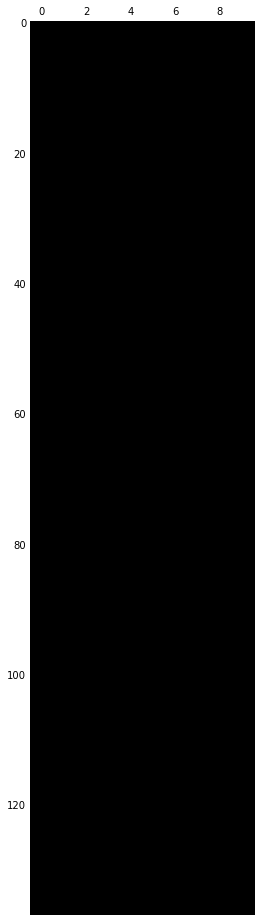

In [27]:
ax = plt.matshow(binary_df, cmap='gray').axes
ax.set_aspect('auto')

In [155]:
from sklearn.cluster.hierarchical import AgglomerativeClustering

In [ ]:
AgglomerativeClustering

In [109]:
plt.show()